In [1]:
%load_ext autoreload
%autoreload 2

import ncem
import scanpy as sc
import numpy as np
from scipy.spatial import KDTree
from anndata import AnnData
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import scanorama

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
datadir = "/Users/anna.schaar/phd/datasets/"

In [4]:
datadir = '/storage/groups/ml01/workspace/anna.schaar/ncem/data/'

# Loading the integrated whole transcriptome adata object

In [26]:
#wt_adata = sc.read_h5ad(datadir + "lu/mnn_corrected_fetal_liver.h5ad")
fetal_liver = sc.read(datadir + "lu/fetal_liver.h5ad")
sorted_hsc = sc.read(datadir + "lu/sorted_HSC.h5ad")

In [27]:
fetal_liver.var_names = [x.decode('utf-8') for x in list(fetal_liver.var_names)]
sorted_hsc.var_names = [x.decode('utf-8') for x in list(sorted_hsc.var_names)]

In [28]:
fetal_liver.obs = fetal_liver.obs.reset_index().drop(['barcode'], axis=1)
sorted_hsc.obs = sorted_hsc.obs.reset_index().drop(['barcode'], axis=1)

In [29]:
sorted_hsc.obs

,n_counts,log_counts,n_genes,mt_frac
0,37804.0,10.540171,5116,0.022670
1,38987.0,10.570984,5341,0.023931
2,11729.0,9.369820,3024,0.057123
3,5437.0,8.600983,2156,0.040463
4,23848.0,10.079455,4338,0.028514
...,...,...,...,...
6481,2474.0,7.813591,1180,0.021827
6482,23477.0,10.063776,4271,0.040848
6483,33613.0,10.422668,5051,0.030048
6484,2948.0,7.988882,1291,0.025102


In [30]:
adatas = [fetal_liver, sorted_hsc]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 14937 genes among all datasets
[[0.         0.38161274]
 [0.         0.        ]]
Processing datasets (0, 1)


In [32]:
adatas_cor[0]

AnnData object with n_obs × n_vars = 7788 × 14937
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'chozen_isoform', 'code', 'n_cells'
    obsm: 'X_scanorama'

In [33]:
adata_spatial = adatas_cor[0].concatenate(
    adatas_cor[1],
    batch_key="library_id",
)

AttributeError: Can only use .str accessor with string values!

# Loading the merfish dataset from ncem

In [5]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=datadir + '/lu/',
    data_origin='luwt',
    radius=200,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

merfish_adata = interpreter.data.celldata

Loading data from raw files
registering celldata


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ic

['AEC', 'Erythroid cell', 'Erythroid progenitor', 'Hepatocyte', 'MK', 'Macrophage', 'Myeloid', 'SEC', 'Unknown']
collecting image-wise celldata


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a futu

adding graph-level covariates


100%|██████████| 140/140 [00:00<00:00, 353.21it/s]


Loaded 140 images with complete data from 1 patients over 40864 cells with 132 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 16.576537

 Celldata metadata: {'lateral_resolution': 0.1079, 'fn': 'FinalClusteringResults 190517 WT.csv', 'image_col': 'FOV', 'pos_cols': ['Center_x', 'Center_y'], 'cluster_col': 'CellTypeID_new', 'cluster_col_preprocessed': 'CellTypeID_new_preprocessed', 'scRNAseq_fn': ['fetal_liver.h5ad', 'sorted_HSC.h5ad']}


## Normalizing and log transforming merfish

In [6]:
merfish_adata = merfish_adata[merfish_adata.obs['CellTypeID_new_preprocessed'] != 'Unknown']

sc.pp.normalize_total(merfish_adata, target_sum=1e5)
sc.pp.log1p(merfish_adata)

sc.pp.highly_variable_genes(merfish_adata, n_top_genes=20)
hvg_merfish = [x for i, x in enumerate(merfish_adata.var_names) if list(merfish_adata.var['highly_variable'])[i]]

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Get the intersection of merfish and whole transcriptome markers for mnn data integration

In [7]:
integration_markers = list(set.intersection(set(merfish_adata.var_names), set(fetal_liver.var_names), set(sorted_hsc.var_names)))

In [ ]:
mnn_corrected = sc.external.pp.mnn_correct(merfish_adata[:,integration_markers], sorted_hsc[:,integration_markers], do_concatenate=False, k=25)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7f299414e3a0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/numba/core/typing/templates.py:710

During: resolving callee type: Function(<function norm at 0x7f299414e3a0>)
During: typing of call at /home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/mnnpy/utils.p

Performing cosine normalization...


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7f299414e3a0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
      With argument(s): '(x=array(float32, 2d, A), axis=int64)':
     Rejected as the implementation raised a specific error:
       TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/numba/core/typing/templates.py:710

During: resolving callee type: Function(<function norm at 0x7f299414e3a0>)
During: typing of call at /home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/mnn

In [9]:
test = sc.external.pp.mnn_correct(wt_adata[:,integration_markers], merfish_adata[:,integration_markers], do_concatenate=True, k=25)[0]

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [10]:
integrated_merfish = mnn_corrected[0][1]

In [11]:
tree = KDTree(wt_adata[:,integration_markers].X)
dd, ii = tree.query(integrated_merfish.X, k=25)

In [12]:
imputed_wt = []
for i in range(integrated_merfish.shape[0]):
    imputed_wt.append(np.mean(wt_adata[ii[i]].X, axis=0)[np.newaxis, :])
imputed_wt = np.concatenate(imputed_wt)

In [13]:
merfish_wt = AnnData(
    X=pd.DataFrame(imputed_wt, columns=wt_adata.var_names), 
    obs=integrated_merfish.obs
)

In [14]:
control_markers = list(set.intersection(set(integration_markers), set(hvg_merfish)))

Trying to set attribute `.uns` of view, copying.


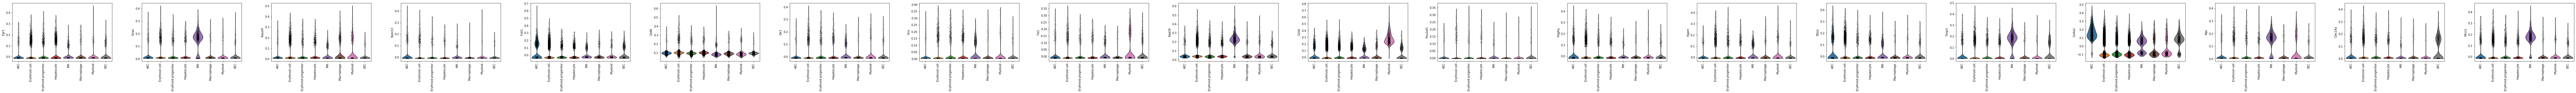

In [15]:
sc.pl.violin(integrated_merfish, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

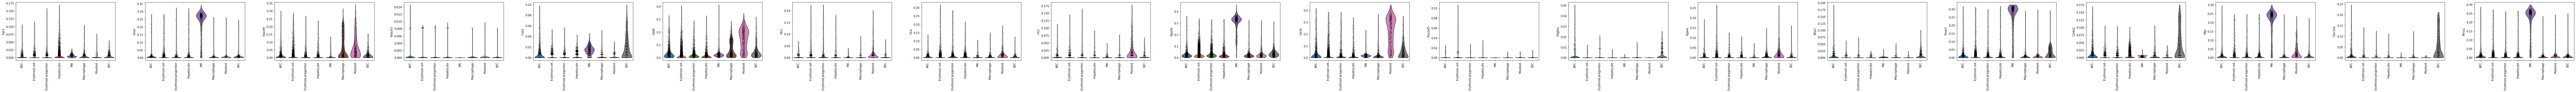

In [16]:
sc.pl.violin(merfish_wt, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

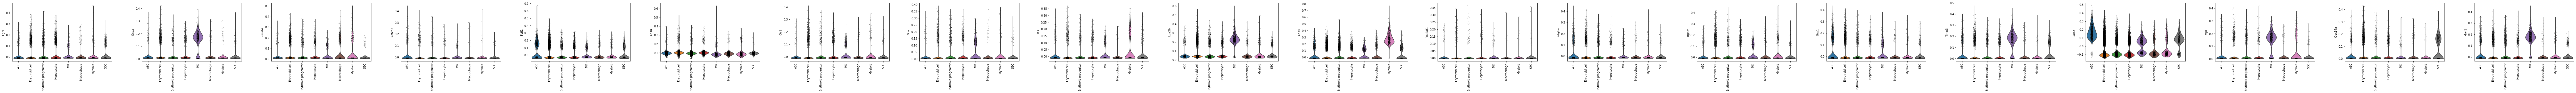

In [17]:
sc.pl.violin(merfish_adata, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

## Sanity checks

In [18]:
control_markers

['Egr1',
 'Gnaz',
 'Rassf4',
 'Notch3',
 'Fstl1',
 'Cd48',
 'Olr1',
 'Gca',
 'Flt3',
 'Itga2b',
 'Cd34',
 'Pou2af1',
 'Pdgfra',
 'Itgam',
 'Sfrp1',
 'Timp3',
 'Col4a1',
 'Mpl',
 'Clec14a',
 'Mrvi1']

Egr1


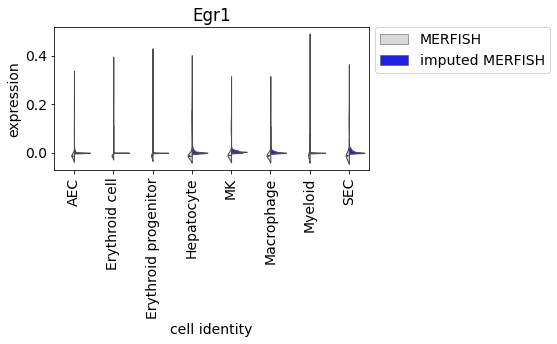

Gnaz


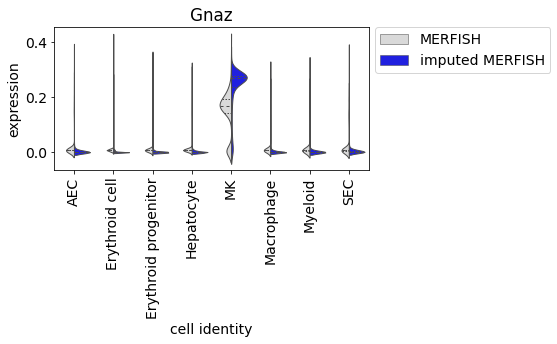

Rassf4


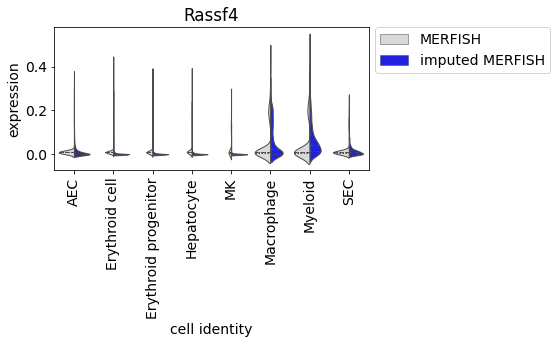

Notch3


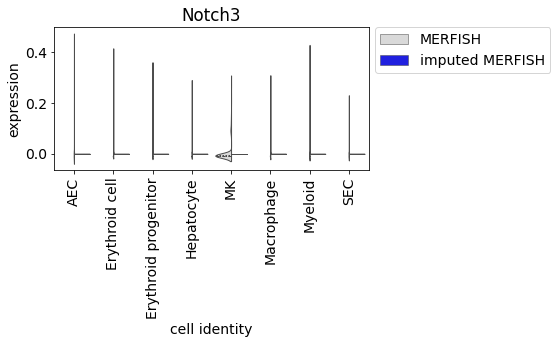

Fstl1


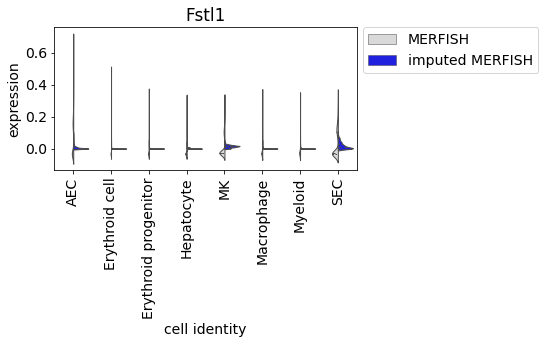

Cd48


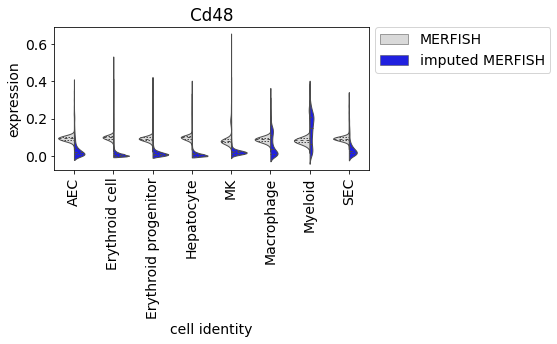

Olr1


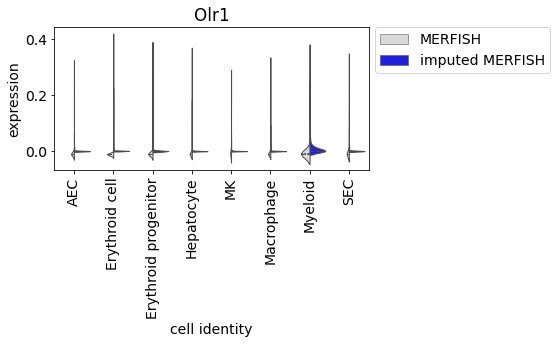

Gca


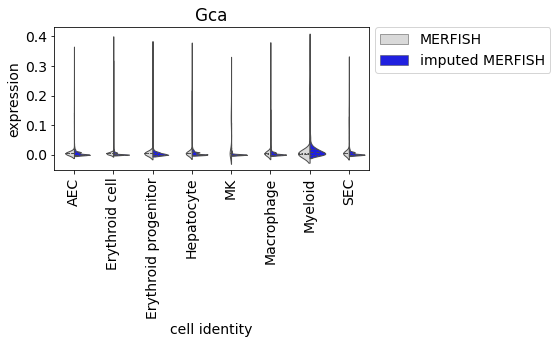

Flt3


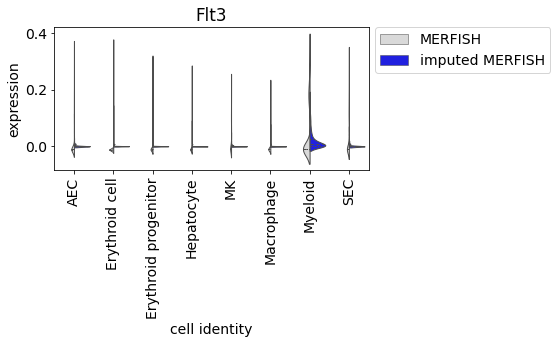

Itga2b


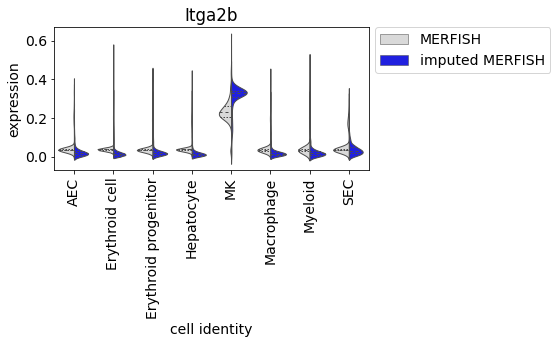

Cd34


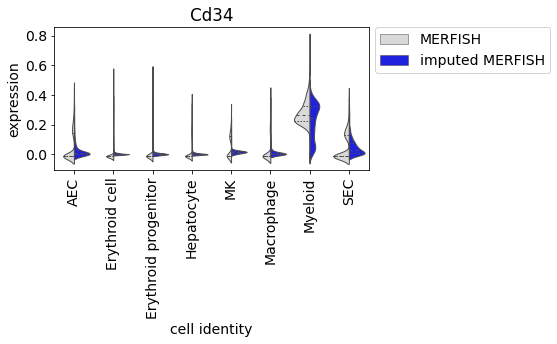

Pou2af1


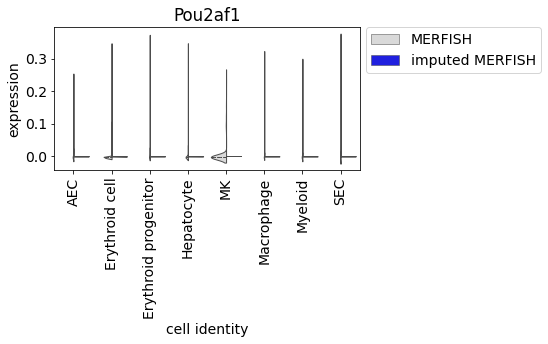

Pdgfra


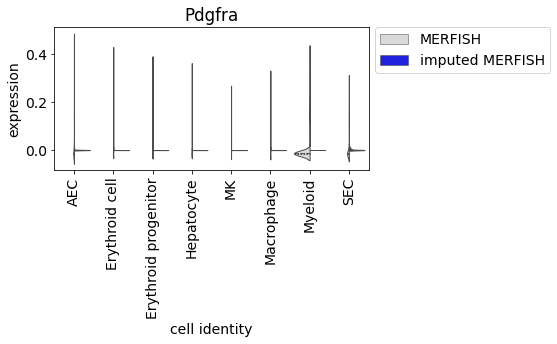

Itgam


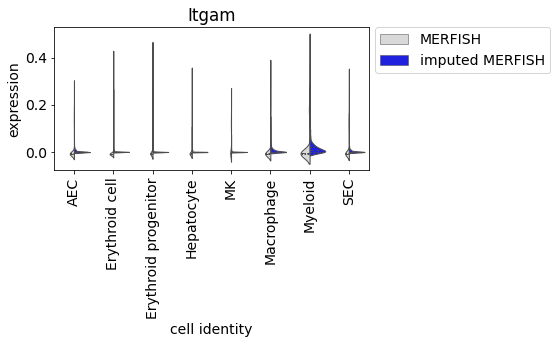

Sfrp1


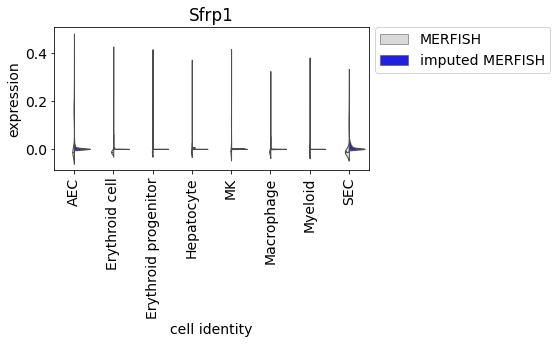

Timp3


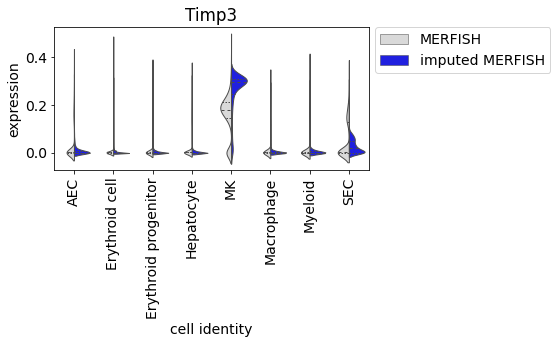

Col4a1


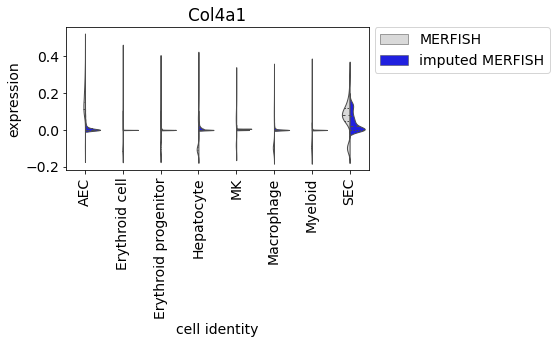

Mpl


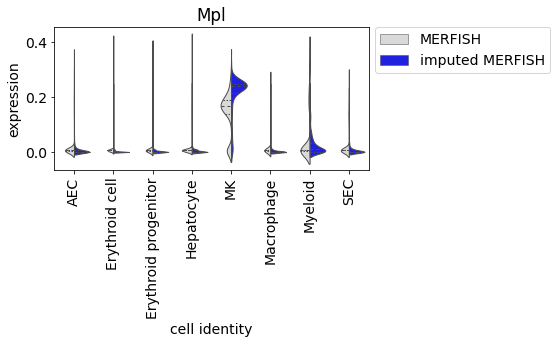

Clec14a


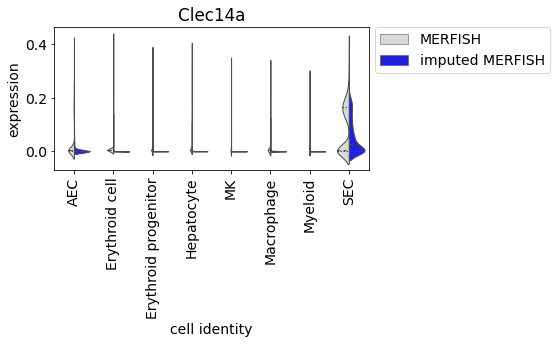

Mrvi1


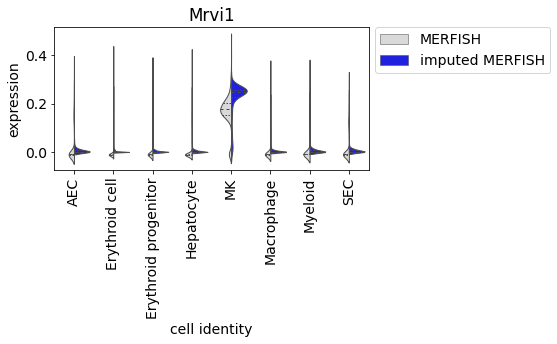

In [19]:
for marker in control_markers:
    print(marker)
    integrated_merfish_check = pd.DataFrame(integrated_merfish[:, [marker]].X, columns=[marker])


    integrated_merfish_check = pd.DataFrame(
        integrated_merfish_check.stack()
    ).reset_index().rename(columns={'level_1': 'gene', 0: 'expression'})
    integrated_merfish_check['cell identity'] = list(integrated_merfish.obs['CellTypeID_new_preprocessed'])

    merfish_wt_check = pd.DataFrame(merfish_wt[:, [marker]].X, columns=[marker])

    merfish_wt_check = pd.DataFrame(
        merfish_wt_check.stack()
    ).reset_index().rename(columns={'level_1': 'gene', 0: 'expression'})
    merfish_wt_check['cell identity'] = list(merfish_wt.obs['CellTypeID_new_preprocessed'])

    integrated_merfish_check['sample'] = 'MERFISH'
    merfish_wt_check['sample'] = 'imputed MERFISH'

    sanity_check = pd.concat([integrated_merfish_check, merfish_wt_check])
    sanity_check = sanity_check[sanity_check['cell identity'] != 'Unknown']

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    sns.violinplot(
        data=sanity_check.sort_values(by=['cell identity']), x='cell identity', 
        y='expression', inner="quart", hue="sample", 
        split=True, 
        linewidth=1, ax=ax,
        palette={"imputed MERFISH": "b", "MERFISH": ".85"}
    )
    ax.set_title(marker)
    ax.grid(False)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()